# ML in Cybersecurity: Project II

## Team
  * **Team name**:  *SecurityMonks*
  * **Members**:  *Soumya Ranjan Sahoo (s8sosaho@stud.uni-saarland.de), Vinit Hegiste (s8vihegi@stud.uni-saarland.de), Vladislav Skripniuk (s8vlskri@stud.uni-saarland.de)*
  * **Tutor**: *Hossein Hajipour*


## Logistics
  * **Due date**: 9th December 2018, 23:59:59 (to email the completed notebook to your respective tutors). We deduct 25% points for late submissions.
  * Complete this in the previously established **teams of 3**
  * Each team will be assigned a tutor. Mail the notebook (**do NOT share a link**) to the respective TAs before the due date.
  
  
## Timeline
  * 19-Nov-2018: Project 2 hand-out
  * **09-Dec-2018** (23:59:59): Email completed notebook to respective TAs
  * **10-Dec-2018** (12:15-14:00, regular tutorial slot): Teams present their projects
  * 17-Dec-2018 (12:15-14:00, regular tutorial slot): Project 2 discussion and summary
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending them. To this end, we require you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results, though.
 
We will evaluate this criteria in a presentation as for project 1. This will be during the regular tutorial slot on 10th December 12:00-14:00 (same location as last time). In case you have time restrictions during the time of the tutorial, notify us asap!  You can present on your laptops.
 
 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all!) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.0: Initial notebook
 
  ---

In [2]:
import os

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
tf.set_random_seed(42)

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [3]:
import time 
 
import numpy as np 
np.random.seed(42)
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [4]:
# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.

# In case you want to use neural networks, we only support sklearn and keras (With a tensorflow backend).


from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint

K.set_image_dim_ordering('th')

from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier

from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import ElasticNetMethod
from cleverhans.utils_keras import KerasModelWrapper

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [5]:
def identity_func(foo):
    return foo


#
#
# ------- Your Code -------
#
#

def L1(a, b):
    return np.sum(np.abs(a-b), axis=(1,2))

def L2(a, b):
    return np.sqrt(np.sum((a-b)**2, axis=(1,2)))

def Loo(a, b):
    return np.max(np.abs(a-b), axis=(1,2))

# 1. Attacking an ML-model

In this section, we implement an attack ourselves. We then leverage the Cleverhans library to craft adversarial examples. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from your last project.

Hint: you might want to save the trained model to save time later.

### 1.1.1: Setting up the model (5 Points)

Re-use the model from your last project here and train it until it achieves reasonable accuracy (>92%).

In [6]:
#reading data
(x_train,y_train),(x_test,y_test)=mnist.load_data()

x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

x_train = x_train/255.0
x_test = x_test/255.0

#one hot encoding
y_train_onehot = np_utils.to_categorical(y_train)
y_test_onehot = np_utils.to_categorical(y_test)

In [7]:
#
#
# ------- Your Code -------
#
#
from keras.models import load_model
model = load_model('CNN_model.h5')

loss, acc = model.evaluate(x_test[:,None,:,:],y_test_onehot,verbose = 1)
print("Model from Project 1 achieves test set accuracy: {:.2f}%".format(acc*100))

10000/10000 [==============================] - 1s 147us/step
Model from Project 1 achieves test set accuracy: 99.33%


To implement an attack and defense on our own we have to use bare Tensorflow, since Keras is not flexible enough. So we create a graph and copy trained weights to it.

In [8]:
trainable_weights = []

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None,28,28,1], name = "X")
    y = tf.placeholder(tf.int32, shape = [None], name = "y")
    training = tf.placeholder(tf.bool, name='training')
    
conv1 = tf.layers.conv2d(X, filters=32, kernel_size = (4,4),
                         strides = (1,1), padding='VALID',
                         activation = tf.nn.relu, name="conv1")

trainable_weights.append(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv1/kernel')[0])
trainable_weights.append(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv1/bias')[0])

with tf.name_scope("pool1"):
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
     
conv2 = tf.layers.conv2d(pool1, filters=16, kernel_size=(4,4),
                         strides=(1,1), padding="VALID",
                         activation=tf.nn.relu, name="conv2")

trainable_weights.append(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv2/kernel')[0])
trainable_weights.append(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv2/bias')[0])

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    
drop1 = tf.layers.dropout(pool2, 0.3, training=training, name="drop1")

with tf.name_scope("fc1"):
    drop1_flat = tf.reshape(drop1, shape=[-1,4*4*16])
    fc1 = tf.layers.dense(drop1_flat, 128, activation = tf.nn.relu,
                          name = "fc1")
    
trainable_weights.append(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'fc1/kernel')[0])
trainable_weights.append(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'fc1/bias')[0])
    
drop2 = tf.layers.dropout(fc1, 0.3, training=training, name="drop2")

with tf.name_scope("fc2"):
    fc2 = tf.layers.dense(drop2, 32, activation = tf.nn.relu,
                          name = "fc2")
    
trainable_weights.append(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'fc2/kernel')[0])
trainable_weights.append(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'fc2/bias')[0])

with tf.name_scope("output"):
    logits = tf.layers.dense(fc2, 10, name = "logits")
    y_proba = tf.nn.softmax(logits, name="y_proba")
    
trainable_weights.append(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'logits/kernel')[0])
trainable_weights.append(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'logits/bias')[0])
    
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [9]:
def copy_weights(sess, src_weights, dst_weights):
    with sess.as_default():
        for i in range(len(src_weights)):
            assign_op = dst_weights[i].assign(src_weights[i].eval())
            sess.run(assign_op)

In [10]:
copy_weights(K.get_session(), model.trainable_weights, trainable_weights)

In [11]:
print("Accuracy after copying weights is: {:.2f}%".format(100 * accuracy.eval(feed_dict={X: x_test[:,:,:,None], y: y_test, training: False}, session=K.get_session())))

Accuracy after copying weights is: 99.33%


Accuracy didn't change, so our copying procedure is correct.

### 1.1.2: Implementing an attack (20 Points)

We now want you to attack the model trained in the previous step. You are free to choose any attack from the lecture, or implement your own idea. Take into account that the attacker is stealhy and wants to remain undetected: introduce a small change only! To test your attack, craft one adversarial example for the first occurence of each digit class in the training data.

We chose Iterative Fast Gradient Sign Method (https://arxiv.org/abs/1607.02533 ). It makes $n$ updates of the form:

$$x_{adv}^0 = x_{clean}$$

$$x_{adv}^{i+1} = x_{adv}^{i} + \frac{\varepsilon}{n} * sign(\nabla _{x} J(x_{adv}^{i}, y_{true}, \theta))$$
So, in the end $||x_{adv}^n - x_{clean}||_{\infty} \leqslant \varepsilon$

In [23]:
indices = [np.where(y_test == i)[0][0] for i in range(10)]

In [16]:
x_adv = np.array(x_test)

In [17]:
eps = 0.2

In [18]:
grad = tf.gradients(loss, X)[0]

In [19]:
n_steps = 10

for i in range(n_steps):
    evaluated_grad = grad.eval(feed_dict={X: x_adv[:,:,:,None], y: y_test, training: False}, session=K.get_session())
    x_adv = x_adv + (eps / n_steps) * np.sign(evaluated_grad[:,:,:,0])
    x_adv = np.clip(x_adv, 0, 1)

In [20]:
print("Accuracy after I-FGSM is: {:.2f}%".format(
    100 * accuracy.eval(feed_dict={X: x_adv[:,:,:,None], y: y_test, training: False}, session=K.get_session())))

Accuracy after I-FGSM is: 15.75%


### 1.1.3: Visualizing the results (5 Points)

Please visualize the ten adversarial examples you crafted in the previous step.

In [24]:
y_proba_test_pred = y_proba.eval(
    feed_dict={X: x_test[:,:,:,None], y: y_test, training: False}, session=K.get_session())
y_proba_adv_pred = y_proba.eval(
    feed_dict={X: x_adv[:,:,:,None], y: y_test, training: False}, session=K.get_session())

         Clean                               I-FGSM


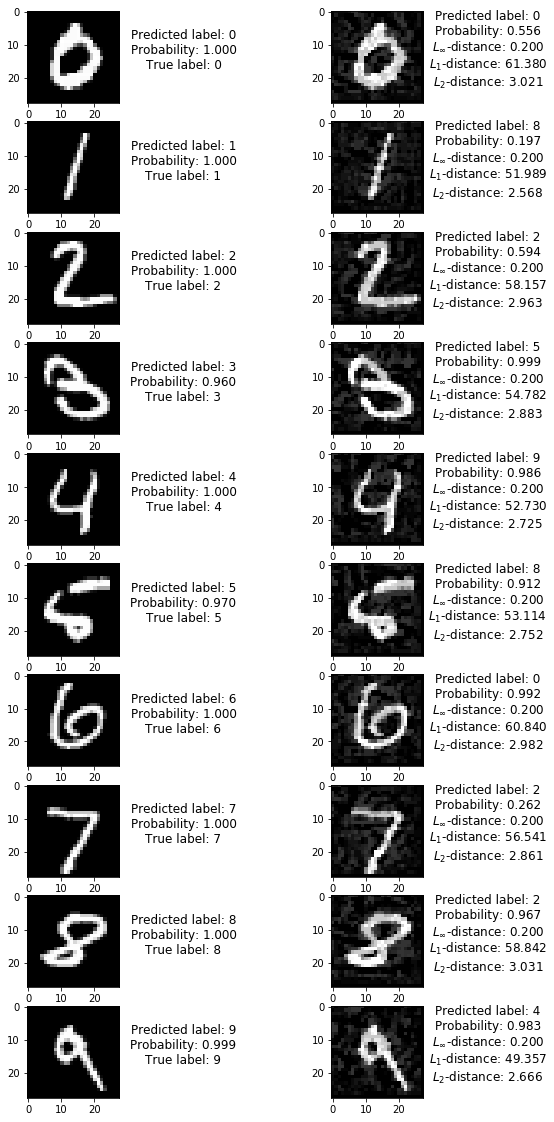

In [26]:
print("         Clean                               I-FGSM")

fig,ax = plt.subplots(nrows=10,ncols=2,figsize=(10,20))

for i in range(10):
    ax[i][0].imshow(x_test[indices[i]])
    ax[i][0].set_title('True label: {}'.format(y_test[indices[i]]), x=1.5, y=0.5)
    ax[i][0].set_title('Predicted label: {}\nProbability: {:.3f}\nTrue label: {}'.format(
        np.argmax(y_proba_test_pred, axis=1)[indices[i]],
        np.max(y_proba_test_pred, axis=1)[indices[i]],
        y_test[indices[i]]), x=1.7, y=0.3)
    ax[i][1].imshow(x_adv[indices[i]])
    ax[i][1].set_title('Predicted label: {}\nProbability: {:.3f}\n$L_\infty$-distance: {:.3f}\n$L_1$-distance: {:.3f}\n$L_2$-distance: {:.3f}'.format(
        np.argmax(y_proba_adv_pred, axis=1)[indices[i]],
        np.max(y_proba_adv_pred, axis=1)[indices[i]],
        Loo(x_test, x_adv)[indices[i]],
        L1(x_test, x_adv)[indices[i]],
        L2(x_test, x_adv)[indices[i]]), x=1.7, y=0.1)
plt.show()

### 1.2.1: Using libraries for attacks (20 Points)
As the field of evasion attacks (in particular for DNN) is very active research field, several libraries have been published that contain attacks. We will work here with the CleverHans (https://github.com/tensorflow/cleverhans) library. Please implement FGSM and another attack of your choice using this library. Please plot for both attacks the resulting adversarial examples as before, craft however a bigger set of at least 1,000 examples using FGSM. 

Fast Gradient Sign Method (https://arxiv.org/abs/1412.6572 ) makes $1$ update of the form:


$$x_{adv} = x_{clean} + \varepsilon * sign(\nabla _{x} J(x_{clean}^{i}, y_{true}, \theta))$$

It makes less refined updates, so it generally is less effective than I-FGSM.

In [203]:
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap, sess=K.get_session())
fgsm_params = {'eps': 0.2,
               'clip_min': 0.,
               'clip_max': 1.}
adv_x = fgsm.generate_np(x_test[:,np.newaxis,:,:], y=y_test_onehot, **fgsm_params)

[INFO 2018-12-09 19:54:26,210 cleverhans] Constructing new graph for attack FastGradientMethod


In [204]:
y_proba_adv_pred = model.predict(adv_x)
y_adv_pred = np.argmax(y_proba_adv_pred, axis=1)

In [205]:
print("Accuracy after FGSM is: {:.2f}%".format(np.mean(y_adv_pred == y_test)*100))

Accuracy after FGSM is: 55.23%


EAD: Elastic-Net Attacks to DNNs (https://arxiv.org/pdf/1709.04114.pdf ) solves the following optimization problem:

$$\min_{x} \quad c f(x, t) + \beta ||x - x_0||_1 + ||x - x_0||_2^2$$
$$\text{subject to } x \in [0,1]^p$$

where $t$ is class label we want the model to predict instead of true label $y$.

$$f(x,t) = \max (\max_{j\neq t}[Logit(x)]_j - [Logit(x)]_t, -k)$$

Untargeted attack just tries all $t \neq y$, and picks the optimal one.

In [154]:
#loading ElasticNetMethod from Cleverhans and generating adverserial examples

wrap = KerasModelWrapper(model)
en = ElasticNetMethod(wrap, sess=K.get_session())
en_params = {"beta":0.01, 
              "decision_rule":'L1',
              "batch_size":1000, 
              "confidence":0, 
              "learning_rate":0.1, 
              "binary_search_steps":9,
              "max_iterations":10,
              "abort_early":True, 
              "initial_const":0.01, 
              "clip_min":0, 
              "clip_max":1}
adv_x1 = en.generate_np(x_test[:,np.newaxis,:,:], y=y_test_onehot, **en_params)

[INFO 2018-12-09 18:27:12,602 cleverhans] Constructing new graph for attack ElasticNetMethod


In [155]:
y_proba_adv_pred1 = model.predict(adv_x1)
y_adv_pred1 = np.argmax(y_proba_adv_pred1, axis=1)

In [156]:
print("Accuracy after Elastic Net attack is: {:.2f}%".format(np.mean(y_adv_pred1 == y_test)*100))

Accuracy after Elastic Net attack is: 0.00%


In [160]:
wrap = KerasModelWrapper(model)
target_en = ElasticNetMethod(wrap, sess=K.get_session())
target_en_params = {"beta":0.01, 
              "decision_rule":'L1',
              "batch_size":1000, 
              "confidence":0, 
              "learning_rate":0.1, 
              "binary_search_steps":9,
              "max_iterations":10,
              "abort_early":True, 
              "initial_const":0.01, 
              "clip_min":0, 
              "clip_max":1}
t_adv_x = target_en.generate_np(x_test[:,np.newaxis,:,:], y_target=np_utils.to_categorical(np.ones((10000,))*9), **target_en_params)

[INFO 2018-12-09 18:32:30,813 cleverhans] Constructing new graph for attack ElasticNetMethod


In [161]:
y_proba_adv_pred2 = model.predict(t_adv_x)
y_adv_pred2 = np.argmax(y_proba_adv_pred2, axis=1)

In [162]:
print("Accuracy after targeted Elastic Net attack is: {:.2f}%".format(np.mean(y_adv_pred2 == y_test)*100))

Accuracy after targeted Elastic Net attack is: 10.09%


In [198]:
np.mean(y_adv_pred2 == 9), np.mean(y_test == 9)

(1.0, 0.1009)

### 1.2.2: Visualizing the results (10 Points)
As before, please plot the results from the previous steps. Compare the results to your own attack. Which differences do you observe between the attacks? Why?

        FGSM                         untargeted Elastic Net               targeted Elastic Net


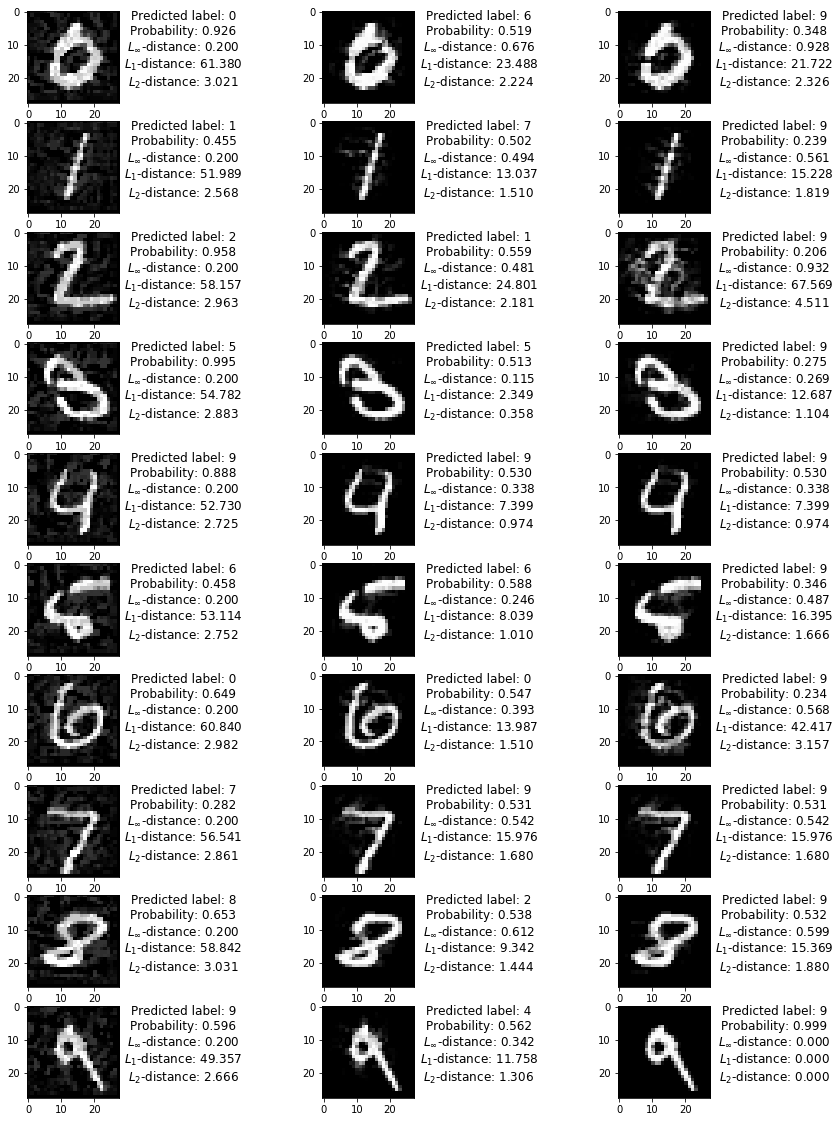

In [177]:
print("        FGSM                         untargeted Elastic Net               targeted Elastic Net")

if len(adv_x1.shape) == 4:
    adv_x1 = adv_x1[:,0,:,:]
    t_adv_x = t_adv_x[:,0,:,:]

fig,ax = plt.subplots(nrows=10,ncols=3,figsize=(15,20))

for i in range(10):
    ax[i][0].imshow(x_adv[indices[i]])
    ax[i][0].set_title('Predicted label: {}\nProbability: {:.3f}\n$L_\infty$-distance: {:.3f}\n$L_1$-distance: {:.3f}\n$L_2$-distance: {:.3f}'.format(
        np.argmax(y_proba_adv_pred, axis=1)[indices[i]],
        np.max(y_proba_adv_pred, axis=1)[indices[i]],
        Loo(x_test, x_adv)[indices[i]],
        L1(x_test, x_adv)[indices[i]],
        L2(x_test, x_adv)[indices[i]]), x=1.7, y=0.1)
    ax[i][1].imshow(adv_x1[indices[i]])
    ax[i][1].set_title('Predicted label: {}\nProbability: {:.3f}\n$L_\infty$-distance: {:.3f}\n$L_1$-distance: {:.3f}\n$L_2$-distance: {:.3f}'.format(
        np.argmax(y_proba_adv_pred1, axis=1)[indices[i]],
        np.max(y_proba_adv_pred1, axis=1)[indices[i]],
        Loo(x_test, adv_x1)[indices[i]],
        L1(x_test, adv_x1)[indices[i]],
        L2(x_test, adv_x1)[indices[i]]), x=1.7, y=0.1)
    ax[i][2].imshow(t_adv_x[indices[i]])
    ax[i][2].set_title('Predicted label: {}\nProbability: {:.3f}\n$L_\infty$-distance: {:.3f}\n$L_1$-distance: {:.3f}\n$L_2$-distance: {:.3f}'.format(
        np.argmax(y_proba_adv_pred2, axis=1)[indices[i]],
        np.max(y_proba_adv_pred2, axis=1)[indices[i]],
        Loo(x_test, t_adv_x)[indices[i]],
        L1(x_test, t_adv_x)[indices[i]],
        L2(x_test, t_adv_x)[indices[i]]), x=1.7, y=0.1)
plt.show()

Elastic Net attack produces more visually plausible adversarial examples. It does not produce clouds over whole image, since $L_1$ and $L_2$ distances are small, since it directly optimizes those distances.

# 2. Defending an ML model

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. As before concerning the attack, you can chose an example from the lecture, or experiment with any idea you have.

We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

### 2.1: Implementing a defense of your choice (25 Points)
As stated before, feel free to implement a defense or mitigation of your choice. Evaluate the defense on all adversarial examples you obtained from previous steps of this project and report the results.

We've decided to implement Logit Squeezing defence (https://arxiv.org/abs/1803.06373 ).

The idea is to use modified objective during training:
$$J^{clean}(M, \theta) + \lambda \frac{1}{m} \sum_{i=1}^m ||f(x^{i}, \theta)||_2^2$$

where $f$ is logits - output of DNN before softmax.

In [178]:
with tf.name_scope("train_squeeze"):
    squeeze_term = tf.reduce_mean(logits**2)
    squeeze_loss = tf.reduce_mean(xentropy) + squeeze_term
    squeeze_optimizer = tf.train.AdamOptimizer()
    squeeze_training_op = squeeze_optimizer.minimize(squeeze_loss)

In [179]:
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [181]:
sess = K.get_session()

In [182]:
n_epochs = 10
batch_size = 100

with sess.as_default():
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(x_train) // batch_size):
            #this cycle is for dividing step by step the heavy work of each neuron
            X_batch = x_train[iteration*batch_size:iteration*batch_size+batch_size,:,:,None]
            y_batch = y_train[iteration*batch_size:iteration*batch_size+batch_size]
            sess.run(squeeze_training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch, training: True})
        acc_test = accuracy.eval(feed_dict={X: x_test[:,:,:,None], y: y_test, training: False})
        print("Epoch:",epoch+1, "Train accuracy:", acc_train, "test accuracy:", acc_test)

('Epoch:', 1, 'Train accuracy:', 0.98, 'test accuracy:', 0.9802)
('Epoch:', 2, 'Train accuracy:', 0.99, 'test accuracy:', 0.985)
('Epoch:', 3, 'Train accuracy:', 0.99, 'test accuracy:', 0.9875)
('Epoch:', 4, 'Train accuracy:', 0.98, 'test accuracy:', 0.9897)
('Epoch:', 5, 'Train accuracy:', 0.99, 'test accuracy:', 0.9893)
('Epoch:', 6, 'Train accuracy:', 0.99, 'test accuracy:', 0.9894)
('Epoch:', 7, 'Train accuracy:', 0.99, 'test accuracy:', 0.9906)
('Epoch:', 8, 'Train accuracy:', 0.99, 'test accuracy:', 0.9914)
('Epoch:', 9, 'Train accuracy:', 0.99, 'test accuracy:', 0.992)
('Epoch:', 10, 'Train accuracy:', 0.98, 'test accuracy:', 0.9914)


In [183]:
copy_weights(sess, trainable_weights, model.trainable_weights)

In [184]:
loss, acc = model.evaluate(x_test[:,None,:,:],y_test_onehot,verbose = 1)
print("Model trained with Logit Squeezing achieves test set accuracy: {:.2f}%".format(acc*100))

10000/10000 [==============================] - 1s 75us/step
Model trained with Logit Squeezing achieves test set accuracy: 99.14%


In [187]:
x_adv = np.array(x_test)
eps = 0.2
n_steps = 10

for i in range(n_steps):
    evaluated_grad = grad.eval(feed_dict={X: x_adv[:,:,:,None], y: y_test, training: False}, session=K.get_session())
    x_adv = x_adv + (eps / n_steps) * np.sign(evaluated_grad[:,:,:,0])
    x_adv = np.clip(x_adv, 0, 1)

In [188]:
print("Accuracy after I-FGSM is: {:.2f}%".format(
    100 * accuracy.eval(feed_dict={X: x_adv[:,:,:,None], y: y_test, training: False}, session=K.get_session())))

Accuracy after I-FGSM is: 75.72%


In [199]:
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap, sess=K.get_session())
fgsm_params = {'eps': 0.2,
               'clip_min': 0.,
               'clip_max': 1.}
adv_x = fgsm.generate_np(x_test[:,np.newaxis,:,:], y=y_test_onehot, **fgsm_params)

[INFO 2018-12-09 19:52:52,380 cleverhans] Constructing new graph for attack FastGradientMethod


In [200]:
y_proba_adv_pred = model.predict(adv_x)
y_adv_pred = np.argmax(y_proba_adv_pred, axis=1)

In [201]:
print("Accuracy after FGSM is: {:.2f}%".format(np.mean(y_adv_pred == y_test)*100))

Accuracy after FGSM is: 87.21%


In [193]:
wrap = KerasModelWrapper(model)
en = ElasticNetMethod(wrap, sess=sess)
en_params = {"beta":0.01, 
              "decision_rule":'L1',
              "batch_size":1000, 
              "confidence":0, 
              "learning_rate":0.1, 
              "binary_search_steps":9,
              "max_iterations":10,
              "abort_early":True, 
              "initial_const":0.01, 
              "clip_min":0, 
              "clip_max":1}
adv_x = en.generate_np(x_test[:,None,:,:], y=y_test_onehot, **en_params)

[INFO 2018-12-09 19:47:57,621 cleverhans] Constructing new graph for attack ElasticNetMethod


In [194]:
#checking the accuracy of the generated adverserial examples 
adv_conf = model.predict(adv_x)
adv_pred = np.argmax(adv_conf, axis = 1)
adv_acc =  np.mean(np.equal(adv_pred,y_test))


print("After EAD, the accuracy is: {}".format(adv_acc*100))

After EAD, the accuracy is: 25.03


### 2.2: Conclusions (15 Points)
Please interpret the results of your defense here. What did you try to make the classifier more robust? Why did it work? Is the classifier now robust?

Feel free to state any interesting finding you encountered during this project.

We've put all quantitative evaluations in the table below:

|Method |Clean | FGSM   | I-FGSM | EAD |
|----|--|------|----|-----|
|  Usual training |99.33%| 55.23% | 15.75% |0.00%|
|  Logit Squeezing |99.14%| 87.21% | 75.72%|25.03|

**What did you try to make the classifier more robust?**

The idea, which we implemented here, is to train the network to predict labels correctly, while keeping the logits small. Training the DNN with cross-entropy loss function may incentivize the model to predict correct labels more confidently, by making some logits dominate the others, so we penalize large magnitudes of logits.

**Why did it work?**

In paper, authors hypothesize, that Logit Squeezing penalizes the model for being over confident. To explain why this leads to better robustness, we suggest, that penalizing large logits during training makes it more difficult for attack algorithm to increase logit corresponding to wrong class during attack phase.

**Is the classifier now robust?**

Definetily, model is now more robust, as we see consistent improvement over all attack methods. Though DNN even after defense can still be fooled with quite high Attack Success Rate.

**Interesting findings**

It turned out, that results, produced by attack methods depend a lot on chosen distance metric. For instance, FGSM and I-FGSM use $L_\infty$ metric and that causes many pixels to be changed, since only maximal difference matters. Such changes are easily noticable during visual inspection. EAD method uses $L_1$ and $L_2$ metrics, so much smaller number of pixels are changed, leading to less noticeable changes. That shows, that search for appropriate perceptual similarity metric is still an open research question.